### Libraries
There are NO external libraries for IR

In [1]:
# for handling dataframe
import ast
import pandas as pd

# for checking loops
from tqdm.notebook import tqdm

# for computing array
import numpy as np

# for computing tf-idf
import math
import warnings
warnings.filterwarnings(action='ignore')

# for visualizing result
import matplotlib.pyplot as plt

# for building assumptions
import random

### Load Files
Movie scripts used in previous assignment

In [2]:
movie_title_df = pd.read_csv('./imsdb_5categories_title.csv')
movie_title_df.head(4)

,drama,romance,comedy,thriller,crime
0,12 and Holding,10 Things I Hate About You,10 Things I Hate About You,12 Monkeys,15 Minutes
1,12 Monkeys,17 Again,12,127 Hours,44 Inch Chest
2,12 Years a Slave,500 Days of Summer,17 Again,15 Minutes,A Few Good Men
3,127 Hours,"Adjustment Bureau, The",30 Minutes or Less,2012,A Most Violent Year


In [3]:
movie_script_df = pd.read_csv('./imsdb_5categories_token.csv')
movie_script_df.head(4)

,drama,romance,comedy,thriller,crime
0,"['12', 'holding', 'written', 'anthony', 's', '...","['ten', 'things', 'hate', 'written', 'karen', ...","['ten', 'things', 'hate', 'written', 'karen', ...","['twelve', 'monkeys', 'original', 'screenplay'...","['fade', 'words', 'czech', 'airline', 'panning..."
1,"['twelve', 'monkeys', 'original', 'screenplay'...","['17', 'again', 'written', 'jason', 'filardi',...","['cut', 'blacktitle', 'finexterior', 'la', 'da...","['127', 'hours', 'written', 'simon', 'beaufoy'...","['44', 'inch', 'chest', 'written', 'louis', 'm..."
2,"['12', 'years', 'slave', 'written', 'john', 'r...","['500', 'days', 'summer', 'written', 'scott', ...","['17', 'again', 'written', 'jason', 'filardi',...","['fade', 'words', 'czech', 'airline', 'panning...","['few', 'good', 'men', 'written', 'aaron', 'so..."
3,"['127', 'hours', 'written', 'simon', 'beaufoy'...","['adjustment', 'bureau', 'written', 'george', ...","['30', 'minutes', 'less', 'written', 'michael'...","['2012', 'written', 'roland', 'emmerich', 'har...","['violent', 'year', 'written', 'jc', 'chandor'..."


In [4]:
def find_movie_name(genre, idx):
    return movie_title_df[genre][idx]


# find movie name by genre, idx
find_movie_name('romance', 0)

'10 Things I Hate About You'

In [5]:
def str2list(column):
    result = []
    for i in tqdm(range(len(column))):
        str_form = column[i]
        if pd.isnull(str_form): continue
        list_form = ast.literal_eval(str_form)
        result.append(list_form)
    return result


# convert the text format of dataframe to a list format
drama_token_list    = str2list(movie_script_df['drama'])
romance_token_list  = str2list(movie_script_df['romance'])
comedy_token_list   = str2list(movie_script_df['comedy'])
thriller_token_list = str2list(movie_script_df['thriller'])
crime_token_list    = str2list(movie_script_df['crime'])

  0%|          | 0/637 [00:00<?, ?it/s]

  0%|          | 0/637 [00:00<?, ?it/s]

  0%|          | 0/637 [00:00<?, ?it/s]

  0%|          | 0/637 [00:00<?, ?it/s]

  0%|          | 0/637 [00:00<?, ?it/s]

### Basic Settings

In [6]:
# define stopwords
# reference: https://www.textfixer.com/tutorials/common-english-words.txt
with open('./eng_stopwords.txt') as file:
    text = file.read()
stopwords = text.split(',')

In [7]:
def proprocess_query(query):
    # remove special characters
    special_characters = ['!', '?', '"','#','$','%','&','(',')','*','+',
                          '/',':',';','<','=','>','@','[','\\',']','^',
                          '`','{','|','}','~','\t', '\n', '-', ',', '.']
    for i in range(len(query)):
        for ch in special_characters:
            query = query.replace(ch, '')
    
    # lower case and strip
    query = query.lower()
    query = query.strip()
    
    # tokenization and removing stopwords
    word_list = query.split()
    for word in word_list:
        if word in stopwords:
            while word in word_list: word_list.remove(word)
    return word_list

### Boolean model

In [8]:
def make_inverted_index(token_list):
    indexing_terms = {}
    postings_lists = {}
    for i in tqdm(range(len(token_list))):
        for word in token_list[i]:
            
            if word not in indexing_terms:
                indexing_terms[word] = 1
            if word in indexing_terms:
                indexing_terms[word] += 1
            
            if word not in postings_lists:
                postings_lists[word] = []
            if word in postings_lists:
                if i in postings_lists[word]: continue
                else: postings_lists[word].append(i)
    
    return indexing_terms, postings_lists


# after making indexing terms and postings lists
drama_indexing_terms, drama_postings_lists       = make_inverted_index(drama_token_list)
romance_indexing_terms, romance_postings_lists   = make_inverted_index(romance_token_list)
comedy_indexing_terms, comedy_postings_lists     = make_inverted_index(comedy_token_list)
thriller_indexing_terms, thriller_postings_lists = make_inverted_index(thriller_token_list)
crime_indexing_terms, crime_postings_lists       = make_inverted_index(crime_token_list)

  0%|          | 0/637 [00:00<?, ?it/s]

  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/372 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

In [9]:
# define term list
drama_terms    = list(drama_indexing_terms.keys())
romance_terms  = list(romance_indexing_terms.keys())
comedy_terms   = list(comedy_indexing_terms.keys())
thriller_terms = list(thriller_indexing_terms.keys())
crime_terms    = list(crime_indexing_terms.keys())


# define document-term matrix's rows, columns
drama_rows    = len(drama_token_list)
romance_rows  = len(romance_token_list)
comedy_rows   = len(comedy_token_list)
thriller_rows = len(thriller_token_list)
crime_rows    = len(crime_token_list)

print(' Drama    category script counts:', drama_rows)
print(' Romance  category script counts:', romance_rows)
print(' Comedy   category script counts:', comedy_rows)
print(' Thriller category script counts:', thriller_rows)
print(' Crime    category script counts:', crime_rows, '\n')

drama_columns    = len(drama_terms)
romance_columns  = len(romance_terms)
comedy_columns   = len(comedy_terms)
thriller_columns = len(thriller_terms)
crime_columns    = len(crime_terms)

print(' Drama    category word set size:', drama_columns)
print(' Romance  category word set size:', romance_columns)
print(' Comedy   category word set size:', comedy_columns)
print(' Thriller category word set size:', thriller_columns)
print(' Crime    category word set size:', crime_columns)

 Drama    category script counts: 637
 Romance  category script counts: 207
 Comedy   category script counts: 372
 Thriller category script counts: 389
 Crime    category script counts: 218 

 Drama    category word set size: 306613
 Romance  category word set size: 126011
 Comedy   category word set size: 192479
 Thriller category word set size: 201335
 Crime    category word set size: 146753


In [10]:
def make_document_term_matrix(rows, columns, terms, postings_lists):
    '''
    parameters
        rows          : number of documents in a category
        columns       : number of terms in a category
        terms         : words appeared in a category at least once
        postings_lists: created in the last assignment
    '''    
    document_term_matrix = [[0 for i in range(columns)] for j in range(rows)]
    for i in tqdm(range(columns)):   # iteration: number of words
        for j in range(rows):        # iteration: number of docs
            if j in postings_lists[terms[i]]:
                document_term_matrix[j][i] = 1
            else:
                pass
    return document_term_matrix


# after making document-term matrix
drama_dtm    = make_document_term_matrix(drama_rows, drama_columns, drama_terms, drama_postings_lists)
romance_dtm  = make_document_term_matrix(romance_rows, romance_columns, romance_terms, romance_postings_lists)
comedy_dtm   = make_document_term_matrix(comedy_rows, comedy_columns, comedy_terms, comedy_postings_lists)
thriller_dtm = make_document_term_matrix(thriller_rows, thriller_columns, thriller_terms, thriller_postings_lists)
crime_dtm    = make_document_term_matrix(crime_rows, crime_columns, crime_terms, crime_postings_lists)

print(' Drama    category document-term matrix shape:', len(drama_dtm), len(drama_dtm[0]))
print(' Romance  category document-term matrix shape:', len(romance_dtm), len(romance_dtm[0]))
print(' Comedy   category document-term matrix shape:', len(comedy_dtm), len(comedy_dtm[0]))
print(' Thriller category document-term matrix shape:', len(thriller_dtm), len(thriller_dtm[0]))
print(' Crime    category document-term matrix shape:', len(crime_dtm), len(crime_dtm[0]))

  0%|          | 0/306613 [00:00<?, ?it/s]

  0%|          | 0/126011 [00:00<?, ?it/s]

  0%|          | 0/192479 [00:00<?, ?it/s]

  0%|          | 0/201335 [00:00<?, ?it/s]

  0%|          | 0/146753 [00:00<?, ?it/s]

 Drama    category document-term matrix shape: 637 306613
 Romance  category document-term matrix shape: 207 126011
 Comedy   category document-term matrix shape: 372 192479
 Thriller category document-term matrix shape: 389 201335
 Crime    category document-term matrix shape: 218 146753


In [11]:
def make_boolean_query_vector(query, terms):
    '''
    parameters
        query: any input text from user
        terms: set of words used to make query vector
    '''
    # preprocessing texts
    word_list = proprocess_query(query)
    
    # making boolean query vector
    columns = len(terms)
    query_vec = np.zeros(columns)
    for i in range(columns):
        if terms[i] in word_list:
            query_vec[i] = 1
        else:
            query_vec[i] = 0
    return list(query_vec)

In [12]:
def match_doc_and_query_byboolean(genre, dtm, rows, query, terms):
    '''
    parameters
        genre: one of the five categories
        dtm  : document-term matrix for each genre
        rows : number of documents in a category
        query: any input text from user
        terms: set of words used to make query vector
    '''
    # get boolean query vector
    query_vec = make_boolean_query_vector(query, terms)
    exist_idx = [i for i in range(len(query_vec)) if query_vec[i] == 1.]
    exist_num = len(exist_idx)
    
    # find documents that are most relevant to query
    match_list = []
    for i in range(rows):
        current_doc = dtm[i][:]
        match = 0
        
        for idx in exist_idx:
            if current_doc[idx] == 1.:
                match += 1
        match_list.append(match)
        
    most_match = max(match_list)
    matched_movie_list = []
    for i in range(len(match_list)):
        if match_list[i] >= most_match*0.95:
            matched_movie = find_movie_name(genre, i)
            print(f" The related movie to your query in genre '{genre}' is '{matched_movie}'")
            matched_movie_list.append(matched_movie)
    return match_list

### Boolean model: Example

In [13]:
# 'Drama' category
query = "Please holding me tight.\
         Probably he's saying forever.\
         Discover my classroom and students.\
         They're continued in morning."

matched_drama_movie_list = match_doc_and_query_byboolean('drama', drama_dtm, drama_rows, query, drama_terms)

 The related movie to your query in genre 'drama' is '12 and Holding'
 The related movie to your query in genre 'drama' is '187'
 The related movie to your query in genre 'drama' is 'Apt Pupil'
 The related movie to your query in genre 'drama' is 'Theory of Everything, The'
 The related movie to your query in genre 'drama' is 'Twin Peaks'


In [14]:
# 'Romance' category
query = "I love ten things that seen in November against hot summer.\
         They looks so beautiful, really joyful.\
         Imagine what's coming.\
         There's no time to block anything."

matched_romance_movie_list = match_doc_and_query_byboolean('romance', romance_dtm, romance_rows, query, romance_terms)

 The related movie to your query in genre 'romance' is '10 Things I Hate About You'
 The related movie to your query in genre 'romance' is 'Autumn in New York'
 The related movie to your query in genre 'romance' is 'Heavenly Creatures'
 The related movie to your query in genre 'romance' is 'Jane Eyre'
 The related movie to your query in genre 'romance' is 'Marty'
 The related movie to your query in genre 'romance' is 'Out of Sight'
 The related movie to your query in genre 'romance' is 'Spanglish'


In [15]:
# 'Comedy' category
query = "Boys and girls are different.\
         They never work a lot.\
         Amazingly, ladies catch sunglasses and laugh.\
         There's some question about eating."

matched_comedy_movie_list = match_doc_and_query_byboolean('comedy', comedy_dtm, comedy_rows, query, comedy_terms)

 The related movie to your query in genre 'comedy' is '10 Things I Hate About You'
 The related movie to your query in genre 'comedy' is 'Change-Up, The'
 The related movie to your query in genre 'comedy' is 'Man on the Moon'
 The related movie to your query in genre 'comedy' is 'Twins'


In [16]:
# 'Thriller' category
query = "Monkeys are inspired by strong people!\
         Newspapers mean breath carefully.\
         You'll play like lion.\
         There are choices."

matched_thriller_movie_list = match_doc_and_query_byboolean('thriller', thriller_dtm, thriller_rows, query, thriller_terms)

 The related movie to your query in genre 'thriller' is '12 Monkeys'


In [17]:
# 'Crime' category
query = "Money and bills are coming.\
         They're not outdated...\
         It's called America joke.\
         Not a joke, made by dirty story"

matched_crime_movie_list = match_doc_and_query_byboolean('crime', crime_dtm, crime_rows, query, crime_terms)

 The related movie to your query in genre 'crime' is '15 Minutes'
 The related movie to your query in genre 'crime' is 'American Gangster'


### Boolean model: Evaluation
> The evaluation follows the *assumptions* below.
1) *When selecting common elements between query vector and all document vectors, the largest number of common elements was called N.*   

2) *In the above boolean model, only those with more than 0.95\*N common elements between the query vector and document vector were RETRIEVED.*   

3) *If there are 0.9\*N common elements between query vector and document vector, they are assumed to be RELEVANT.*

In [18]:
def plot_evaluation(p1, r1, p2, r2, p3, r3, p4, r4, p5, r5, ver):
    evaluate = [['drama', p1, r1],
                ['romance', p2, r2],
                ['comedy', p3, r3],
                ['thriller', p4, r4],
                ['crime', p5, r5]]
    evaluate_df = pd.DataFrame(evaluate, columns=['genre', 'precision', 'recall'])
    evaluate_df.plot(x='genre', y=['precision', 'recall'], kind='bar', figsize=(20,6))
    plt.title(f'Evaluation: "{ver}"', size=20)
    plt.xticks(size=15, rotation=45)
    plt.legend(fontsize=15)

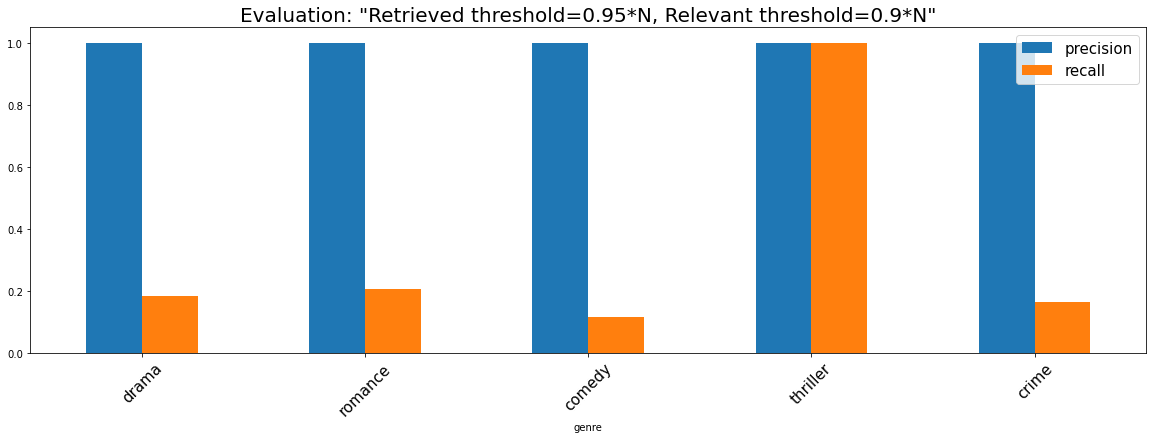

In [19]:
def score_boolean_evaluation(match_list):
    tp = 0     # retrieved - relevant
    fp = 0     # retrieved - nonrelevant
    fn = 0     # not retrieved - relevant
    tn = 0     # not retrieved - nonrelevant
    
    most_match = max(match_list)
    for i in range(len(match_list)):
        if match_list[i] >= most_match*0.95:
            tp += 1
        elif (match_list[i] < most_match*0.95) and (match_list[i] >= most_match*0.9):
            fn += 1
        elif match_list[i] < most_match*0.9:
            tn += 1
        # there is NO case 'fp' according to the assumption
        # because retrieved threshold is 0.95*N, while relevant threshold is 0.9*N
        
    precision = tp / (tp + fp)
    recall    = tp / (tp + fn)
    return precision, recall


p1, r1 = score_boolean_evaluation(matched_drama_movie_list)
p2, r2 = score_boolean_evaluation(matched_romance_movie_list)
p3, r3 = score_boolean_evaluation(matched_comedy_movie_list)
p4, r4 = score_boolean_evaluation(matched_thriller_movie_list)
p5, r5 = score_boolean_evaluation(matched_crime_movie_list)
plot_evaluation(p1, r1, p2, r2, p3, r3, p4, r4, p5, r5, 'Retrieved threshold=0.95*N, Relevant threshold=0.9*N')

### Vector space model

In [20]:
def make_term_frequency(token_list, terms):
    '''
    parameters
        token_list : tokens in each script
        terms      : words appeared in a category at least once
    '''
    rows    = len(token_list)
    columns = len(terms)
    
    term_frequency = [[0 for i in range(columns)] for j in range(rows)]
    for j in tqdm(range(rows)):
        for token in token_list[j]:
            i = terms.index(token)
            term_frequency[j][i] += 1
    return term_frequency


# after making term-frequency matrix
drama_tf    = make_term_frequency(drama_token_list, drama_terms)
romance_tf  = make_term_frequency(romance_token_list, romance_terms)
comedy_tf   = make_term_frequency(comedy_token_list, comedy_terms)
thriller_tf = make_term_frequency(thriller_token_list, thriller_terms)
crime_tf    = make_term_frequency(crime_token_list, crime_terms)

  0%|          | 0/637 [00:00<?, ?it/s]

  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/372 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

In [21]:
def make_tfidf_matrix(terms, term_frequency, indexing_terms, postings_lists):
    '''
    parameters
        terms         : words appeared in a category at least once
        term_frequency: term-frequency matrix for each genre
        indexing_terms: created in the last assignment
        postings_lists: created in the last assignment
    '''
    rows    = len(term_frequency)
    columns = len(term_frequency[0])
    
    tfidf_matrix = [[0 for i in range(columns)] for j in range(rows)]
    for i in tqdm(range(columns)):   # iteration: number of words
        for j in range(rows):        # iteration: number of docs
            if j in postings_lists[terms[i]]:
                tf = term_frequency[j][i]
                idf = math.log2(rows / len(postings_lists[terms[i]]))
                tfidf_matrix[j][i] = tf * idf
            else:
                pass
    return tfidf_matrix


# after making tfidf matrix
drama_tim    = make_tfidf_matrix(drama_terms, drama_tf, drama_indexing_terms, drama_postings_lists)
romance_tim  = make_tfidf_matrix(romance_terms, romance_tf, romance_indexing_terms, romance_postings_lists)
comedy_tim   = make_tfidf_matrix(comedy_terms, comedy_tf, comedy_indexing_terms, comedy_postings_lists)
thriller_tim = make_tfidf_matrix(thriller_terms, thriller_tf, thriller_indexing_terms, thriller_postings_lists)
crime_tim    = make_tfidf_matrix(crime_terms, crime_tf, crime_indexing_terms, crime_postings_lists)

print(' Drama    category tfidf matrix shape:', len(drama_tim), len(drama_tim[0]))
print(' Romance  category tfidf matrix shape:', len(romance_tim), len(romance_tim[0]))
print(' Comedy   category tfidf matrix shape:', len(comedy_tim), len(comedy_tim[0]))
print(' Thriller category tfidf matrix shape:', len(thriller_tim), len(thriller_tim[0]))
print(' Crime    category tfidf matrix shape:', len(crime_tim), len(crime_tim[0]))

  0%|          | 0/306613 [00:00<?, ?it/s]

  0%|          | 0/126011 [00:00<?, ?it/s]

  0%|          | 0/192479 [00:00<?, ?it/s]

  0%|          | 0/201335 [00:00<?, ?it/s]

  0%|          | 0/146753 [00:00<?, ?it/s]

 Drama    category tfidf matrix shape: 637 306613
 Romance  category tfidf matrix shape: 207 126011
 Comedy   category tfidf matrix shape: 372 192479
 Thriller category tfidf matrix shape: 389 201335
 Crime    category tfidf matrix shape: 218 146753


In [22]:
def make_tfidf_query_vector(query, rows, terms, postings_lists):
    '''
    parameters
        query: any input text from user
        rows : number of documents in a category
        terms: set of words used to make query vector
    '''
    # preprocessing texts
    word_list = proprocess_query(query)
    
    # making term-frequency
    columns = len(terms)
    term_frequency = [0 for i in range(columns)]
    for token in word_list:
        i = terms.index(token)
        term_frequency[i] += 1
    
    # making tfidf query vector
    query_vec = [0 for i in range(columns)]
    for i in range(columns):
        tf = term_frequency[i]
        idf = math.log2(rows / len(postings_lists[terms[i]]))
        query_vec[i] = tf * idf
    return list(query_vec)

In [23]:
def match_doc_and_query_byvector(genre, tim, query, terms, postings_lists):
    '''
    parameters
        genre: one of the five categories
        tim  : tfidf matrix for each genre
        query: any input text from user
        terms: set of words used to make query vector
    '''
    # get tfidf query vector
    rows = len(tim)
    query_vec = make_tfidf_query_vector(query, rows, terms, postings_lists)
    query_vec = np.array(query_vec)
    
    # calculate cos similarity
    cossim_list = []
    for i in range(rows):
        current_doc = np.array(tim[i][:])
        cossim = cos_similarity(query_vec, current_doc)
        cossim_list.append([cossim, i])
    cossim_list.sort(key=lambda x: -x[0])
    
    # find documents that are most relevant to query
    print(f" TOP 10 movies to your query in genre '{genre}' are...")
    matched_movie_list = cossim_list[:10]
    for i in range(len(matched_movie_list)):
        matched_movie = find_movie_name(genre, matched_movie_list[i][1])
        print(f"  '%-30s' " % matched_movie, end='')
        print(f'with score {matched_movie_list[i][0]}')
    return matched_movie_list


def cos_similarity(vec1, vec2):
    return np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))

### Vector space model: Example

In [24]:
# 'Drama' category
query = "Please holding me tight.\
         Probably he's saying forever.\
         Discover my classroom and students.\
         They're continued in morning."

matched_drama_movie_list = match_doc_and_query_byvector('drama', drama_dtm, query, drama_terms, drama_postings_lists)

 TOP 10 movies to your query in genre 'drama' are...
  '12 and Holding                ' with score 0.04890273811399546
  'Apt Pupil                     ' with score 0.040419990012928744
  '187                           ' with score 0.0358933582165348
  'Almost Famous                 ' with score 0.02938131941458541
  'Ali                           ' with score 0.028607373702858586
  'American Splendor             ' with score 0.027571239565206948
  'American Gangster             ' with score 0.026189930550036617
  '50-50                         ' with score 0.026027418014808682
  'An Education                  ' with score 0.025129429693557772
  'After.Life                    ' with score 0.024825005481282768


In [25]:
# 'Romance' category
query = "I love ten things that seen in November against hot summer.\
         They looks so beautiful, really joyful.\
         Imagine what's coming.\
         There's no time to block anything."

matched_romance_movie_list = match_doc_and_query_byvector('romance', romance_tim, query, romance_terms, romance_postings_lists)

 TOP 10 movies to your query in genre 'romance' are...
  '500 Days of Summer            ' with score 0.07058284286157498
  'Artist, The                   ' with score 0.0034213392071774824
  'Brothers Bloom, The           ' with score 0.0033127129333557943
  '10 Things I Hate About You    ' with score 0.002410674987584413
  'Clueless                      ' with score 0.002354104552827887
  'Almost Famous                 ' with score 0.002254437882465098
  'Autumn in New York            ' with score 0.00196422785268089
  'American President, The       ' with score 0.001930453104120181
  'Bruce Almighty                ' with score 0.001365393788235247
  'Cooler, The                   ' with score 0.0011099663255404472


In [26]:
# 'Comedy' category
query = "Boys and girls are different.\
         They never work a lot.\
         Amazingly, ladies catch sunglasses and laugh.\
         There's some question about eating."

matched_comedy_movie_list = match_doc_and_query_byvector('comedy', comedy_dtm, query, comedy_terms, comedy_postings_lists)

 TOP 10 movies to your query in genre 'comedy' are...
  '10 Things I Hate About You    ' with score 0.03927447047913445
  'American Pie                  ' with score 0.03162680167058886
  'Drop Dead Gorgeous            ' with score 0.031191640447265058
  'Fatal Instinct                ' with score 0.03099965604755074
  'Devil Wears Prada, The        ' with score 0.02772157020454454
  'Entrapment                    ' with score 0.027134010113659946
  'Croods, The                   ' with score 0.026956611006231552
  'Back-up Plan, The             ' with score 0.02658907004905023
  '48 Hrs.                       ' with score 0.025446718861336155
  '500 Days of Summer            ' with score 0.02392951683692961


In [27]:
# 'Thriller' category
query = "Monkeys are inspired by strong people!\
         Newspapers mean breath carefully.\
         You'll play like lion.\
         There are choices."

matched_thriller_movie_list = match_doc_and_query_byvector('thriller', thriller_dtm, query, thriller_terms, thriller_postings_lists)

 TOP 10 movies to your query in genre 'thriller' are...
  '12 Monkeys                    ' with score 0.03565008961896475
  'Adjustment Bureau, The        ' with score 0.01882440177767354
  'Basic                         ' with score 0.018593336125182082
  'Avventura, L' (The Adventure) ' with score 0.015792793091269873
  '8MM                           ' with score 0.014280168676499028
  'Black Dahlia, The             ' with score 0.014269050898844698
  'Batman 2                      ' with score 0.013735337514713534
  'Birds, The                    ' with score 0.012269021027917234
  '15 Minutes                    ' with score 0.011713840925709804
  'Air Force One                 ' with score 0.01131386922858502


In [28]:
# 'Crime' category
query = "Money and bills are coming.\
         They're not outdated...\
         It's called America joke.\
         Not a joke, made by dirty story"

matched_crime_movie_list = match_doc_and_query_byvector('crime', crime_dtm, query, crime_terms, crime_postings_lists)

 TOP 10 movies to your query in genre 'crime' are...
  '15 Minutes                    ' with score 0.031020131219329932
  'American Gangster             ' with score 0.02601192275342815
  'Bound                         ' with score 0.012319345252069147
  'Catch Me If You Can           ' with score 0.01226406675056572
  'Analyze That                  ' with score 0.011948710212007906
  'BlacKkKlansman                ' with score 0.011853095382854537
  'Batman                        ' with score 0.011555054998641213
  'Capote                        ' with score 0.011501321308417021
  'Black Rain                    ' with score 0.011288029388025853
  'Chinatown                     ' with score 0.011052800798142377


### Vector space model: Evaluation
> The MAP evaluation follows the *assumptions* below.
1) *In the above vector space model, only RETRIEVED the top 10 cos similarity movies between query vector and document vector.*   

2) *Among them, only 3~5 randomly selected movies are assumed to be RELEVANT.*

In [29]:
def plot_evaluation(p1, r1, p2, r2, p3, r3, p4, r4, p5, r5, ver):
    evaluate = [['drama', p1, r1],
                ['romance', p2, r2],
                ['comedy', p3, r3],
                ['thriller', p4, r4],
                ['crime', p5, r5]]
    evaluate_df = pd.DataFrame(evaluate, columns=['genre', 'MAP', 'MAR'])
    evaluate_df.plot(x='genre', y=['MAP', 'MAR'], kind='bar', figsize=(20,6))
    plt.title(f'Evaluation: "{ver}"', size=20)
    plt.xticks(size=15, rotation=45)
    plt.legend(fontsize=15)

In [30]:
def select_random_relevant(five=False):
    if five: randnum = 5
    else: randnum = random.randint(3, 5)
        
    randidx = []
    for i in range(randnum):
        while True:
            idx = random.randint(0, 9)
            if idx not in randidx:
                randidx.append(idx)
                break       
    
    relevant = []
    for i in range(10):
        if i in randidx:
            relevant.append(1)
        else:
            relevant.append(0)
    return relevant


# set movie scripts are whether RELEVANT or not
drama_relevant1    = select_random_relevant()
romance_relevant1  = select_random_relevant()
comedy_relevant1   = select_random_relevant()
thriller_relevant1 = select_random_relevant()
crime_relevant1    = select_random_relevant()

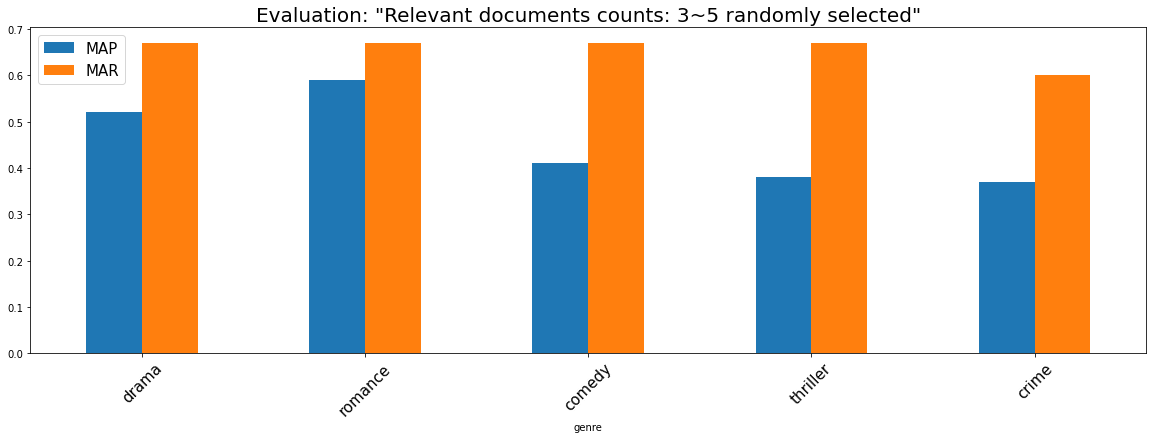

In [31]:
def score_mean_average_evaluation(relevant):
    recall    = []
    precision = []
    relevant_num = relevant.count(1)     # number of relevant documents
    relevant_cnt = 0                     # number of appearing relevant documents
    relevant_idx = [i for i in range(len(relevant)) if relevant[i] == 1]     # index of relevant documents
    
    for i in range(len(relevant)):
        cur_doc = relevant[i]
        
        if cur_doc == 1:
            relevant_cnt += 1    
            # compute recall at current document
            cur_recall = relevant_cnt / relevant_num
            recall.append(np.round(cur_recall, 2))
        else:
            # compute recall at current document
            try:
                cur_recall = recall[i-1]
                recall.append(np.round(cur_recall, 2))
            except:
                cur_recall = 0.0
                recall.append(cur_recall)
        
        # compute precision at current document
        cur_precision = relevant_cnt / (i+1)
        precision.append(np.round(cur_precision, 2))
            
    # compute recall & precision at relevant documents
    relevant_recall    = [] 
    relevant_precision = []
    for idx in relevant_idx:
        cur_recall    = recall[idx]
        cur_precision = precision[idx]
        relevant_recall.append(cur_recall)
        relevant_precision.append(cur_precision)
        
    MAP = np.round(np.mean(relevant_precision) , 2)
    MAR = np.round(np.mean(relevant_recall), 2)
    return MAP, MAR   
    
    
p1, r1 = score_mean_average_evaluation(drama_relevant1)
p2, r2 = score_mean_average_evaluation(romance_relevant1)
p3, r3 = score_mean_average_evaluation(comedy_relevant1)
p4, r4 = score_mean_average_evaluation(thriller_relevant1)
p5, r5 = score_mean_average_evaluation(crime_relevant1)
plot_evaluation(p1, r1, p2, r2, p3, r3, p4, r4, p5, r5, 'Relevant documents counts: 3~5 randomly selected')

> The NDCG follows the *assumptions* below.
1) *In the above vector space model, only RETRIEVED the top 10 cos similarity movies between query vector and document vector.*   

2) *Among them, only 5 randomly selected movies are assumed to be RELEVANT.*

3) *Cos similarity is treated as a 'relevance' in each movie.*

In [32]:
# set movie scripts are whether RELEVANT or not
drama_relevant2    = select_random_relevant(five=True)
romance_relevant2  = select_random_relevant(five=True)
comedy_relevant2   = select_random_relevant(five=True)
thriller_relevant2 = select_random_relevant(five=True)
crime_relevant2    = select_random_relevant(five=True)

In [33]:
def score_ndcg(matched_movie_list, relevant):
    rel = []     # relevance of retrieved movies
    idx = []     # index of retrieved movies   
    for i in range(10):
        rel.append(np.round(matched_movie_list[i][0], 5))
        idx.append(matched_movie_list[i][1])

    # make nonrelevant movie's relevance = 0
    relevant_idx    = [i for i in range(len(relevant)) if relevant[i] == 1]     # index of relevant documents
    nonrelevant_idx = []
    for i in range(10):
        if i not in relevant_idx:
            rel[i] = 0
            nonrelevant_idx.append(i)

    # compute dcg
    log = [np.round(math.log2(i), 5) for i in range(1, 11, 1)]
    dcg = []
    for i in range(10):
        if i == 0: cur_dcg = rel[0]
        else: cur_dcg = dcg[i-1] + (rel[i]/log[i])
        dcg.append(np.round(cur_dcg, 5))
    
    # newly aligned relevance & index by idcg
    new_rel = []   
    new_idx = []
    for i in relevant_idx:
        new_rel.append(rel[i])
        new_idx.append(idx[i])
    for i in nonrelevant_idx:
        new_rel.append(rel[i])
        new_idx.append(idx[i])
    
    # compute idcg
    idcg = []
    for i in range(10):
        if i == 0: cur_idcg = new_rel[0]
        else: cur_idcg = idcg[i-1] + (new_rel[i]/log[i])
        idcg.append(np.round(cur_idcg, 5))
       
    # compute ndcg
    ndcg = []
    for i in range(10):
        cur_ndcg = dcg[i] / idcg[i]
        ndcg.append(np.round(cur_ndcg, 5))
    
    ndcg_df = pd.DataFrame({'doc#': idx, 'relevance': rel, 'DCG': dcg, 'IDCG': idcg, 'NDCG': ndcg})
    return ndcg_df

In [34]:
# 'Drama' category, Relevant documents counts: 5 randomly selected
drama_ndcg = score_ndcg(matched_drama_movie_list, drama_relevant2)
drama_ndcg

,doc#,relevance,DCG,IDCG,NDCG
0,0,0.00000,0.00000,0.04042,0.00000
1,56,0.04042,0.04042,0.07631,0.52968
2,6,0.03589,0.06306,0.09485,0.66484
3,32,0.02938,0.07775,0.10916,0.71226
4,26,0.02861,0.09007,0.11998,0.75071
5,44,0.00000,0.09007,0.11998,0.75071
6,36,0.00000,0.09007,0.11998,0.75071
7,11,0.00000,0.09007,0.11998,0.75071
8,47,0.02513,0.09800,0.11998,0.81680
9,23,0.00000,0.09800,0.11998,0.81680


In [35]:
# 'Romance' category, Relevant documents counts: 5 randomly selected
romance_ndcg = score_ndcg(matched_romance_movie_list, romance_relevant2)
romance_ndcg

,doc#,relevance,DCG,IDCG,NDCG
0,2,0.00000,0.00000,0.00342,0.00000
1,12,0.00342,0.00342,0.00583,0.58662
2,35,0.00000,0.00342,0.00731,0.46785
3,0,0.00241,0.00462,0.00800,0.57750
4,45,0.00235,0.00563,0.00848,0.66392
5,6,0.00000,0.00563,0.00848,0.66392
6,14,0.00000,0.00563,0.00848,0.66392
7,7,0.00000,0.00563,0.00848,0.66392
8,36,0.00137,0.00606,0.00848,0.71462
9,48,0.00111,0.00639,0.00848,0.75354


In [36]:
# 'Comedy' category, Relevant documents counts: 5 randomly selected
comedy_ndcg = score_ndcg(matched_comedy_movie_list, comedy_relevant2)
comedy_ndcg

,doc#,relevance,DCG,IDCG,NDCG
0,0,0.03927,0.03927,0.03927,1.00000
1,21,0.00000,0.03927,0.07046,0.55734
2,116,0.03119,0.05895,0.09002,0.65485
3,134,0.03100,0.07445,0.10332,0.72058
4,110,0.00000,0.07445,0.11428,0.65147
5,124,0.00000,0.07445,0.11428,0.65147
6,98,0.00000,0.07445,0.11428,0.65147
7,42,0.02659,0.08331,0.11428,0.72900
8,4,0.02545,0.09134,0.11428,0.79926
9,6,0.00000,0.09134,0.11428,0.79926


In [37]:
# 'Thriller' category, Relevant documents counts: 5 randomly selected
thriller_ndcg = score_ndcg(matched_thriller_movie_list, thriller_relevant2)
thriller_ndcg

,doc#,relevance,DCG,IDCG,NDCG
0,0,0.00000,0.00000,0.01859,0.00000
1,9,0.00000,0.00000,0.03287,0.00000
2,39,0.01859,0.01173,0.04187,0.28015
3,32,0.00000,0.01173,0.04772,0.24581
4,5,0.01428,0.01788,0.05259,0.33999
5,46,0.01427,0.02340,0.05259,0.44495
6,42,0.00000,0.02340,0.05259,0.44495
7,45,0.00000,0.02340,0.05259,0.44495
8,2,0.01171,0.02709,0.05259,0.51512
9,11,0.01131,0.03049,0.05259,0.57977


In [38]:
# 'Crime' category, Relevant documents counts: 5 randomly selected
crime_ndcg = score_ndcg(matched_crime_movie_list, crime_relevant2)
crime_ndcg

,doc#,relevance,DCG,IDCG,NDCG
0,0,0.03102,0.03102,0.03102,1.00000
1,8,0.02601,0.05703,0.05703,1.00000
2,39,0.01232,0.06480,0.06480,1.00000
3,45,0.00000,0.06480,0.07058,0.91811
4,12,0.00000,0.06480,0.07544,0.85896
5,28,0.00000,0.06480,0.07544,0.85896
6,21,0.01156,0.06892,0.07544,0.91357
7,43,0.00000,0.06892,0.07544,0.91357
8,27,0.01129,0.07248,0.07544,0.96076
9,50,0.00000,0.07248,0.07544,0.96076
